# Example ESASky use

This notebook illustrates some relatively more advanced usages of the ESASky implementation as a module of  `astroquery`.

Authors: Ivan Valtchanov et al.

First you need to install `astroquery` which contains esasky.

Astroquery can be installed with `pip install --pre astroquery`, the latest version should come with esasky. 

The documentation for `astroquery.esasky` is available [here](https://astroquery.readthedocs.io/en/latest/esasky/esasky.html).


In [38]:
#
# import some necessary packages
#
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

%matplotlib inline

import numpy as np

from astropy.wcs import WCS
from astropy.visualization import PercentileInterval, ImageNormalize, AsinhStretch, LogStretch, LinearStretch
from astroquery.esasky import ESASky
from astropy.convolution import convolve, Kernel, Gaussian2DKernel

## Workflow

This is a simple workflow.

1. Load an XMM-Newton EPIC image of a target of choice
2. Smooth the image with a Gaussian with FWHM=5"
3. Generate 10 contours
4. Plot the original photon image in [0.2-7] keV (ESASky data) and overplot the contours
5. Load a Herschel 250 µm image of the same target
6. Plot the Herschel image and overplot the XMM smoothed image contours
7. Overplot the the 3XMM point-source catalogue sources
8. Overplot the Planck PSZ catalogue sources

In [39]:
ESASky.list_maps()


['INTEGRAL',
 'XMM',
 'Chandra',
 'SUZAKU',
 'XMM-OM-OPTICAL',
 'XMM-OM-UV',
 'HST-UV',
 'HST-OPTICAL',
 'HST-IR',
 'ISO-IR',
 'Herschel',
 'AKARI',
 'Spitzer',
 'ALMA']

In [40]:
maps = ESASky.query_object_maps(position='M51', missions=["XMM","HERSCHEL"])
print (maps)

TableList with 2 tables:
	'0:XMM' with 15 column(s) and 11 row(s) 
	'1:HERSCHEL' with 15 column(s) and 9 row(s) 


In [41]:
ESASky.list_catalogs()

['LAMOST',
 'AllWise',
 'AKARI-IRC-SC',
 'TwoMASS',
 'INTEGRAL',
 'CHANDRA-SC2',
 'XMM-EPIC-STACK',
 'XMM-EPIC',
 'XMM-OM',
 'XMM-SLEW',
 'Tycho-2',
 'Gaia-eDR3',
 'Hipparcos-2',
 'HSC',
 'Herschel-HPPSC-070',
 'Herschel-HPPSC-100',
 'Herschel-HPPSC-160',
 'Herschel-SPSC-250',
 'Herschel-SPSC-350',
 'Herschel-SPSC-500',
 'Planck-PGCC',
 'Planck-PCCS2E-HFI',
 'Planck-PCCS2-HFI',
 'Planck-PCCS2-LFI',
 'Planck-PSZ2']

In [42]:
#
# get information on the content of the results table returned by the query
#
print (maps["XMM"].info)

<Table length=11>
      name       dtype  unit                         description                         
--------------- ------- ---- ------------------------------------------------------------
        dec_deg float64  deg                                                             
       duration   int64    s                           Total exposure time of observation
       end_time  object time                                         Observation End Time
            fov  object                                                                  
     instrument  object                                                        Instrument
           npix   int64      Healpix pixel of the center of the observation for nside 256
 observation_id  object                         The XMM-Newton observation identification
observation_oid   int32                                   Observation internal identifier
 position_angle float64                                                           

In [43]:
#
# and list the observations and their duration
#
maps["XMM"]["observation_id","instrument","duration"].pprint()

observation_id instrument duration
                             s    
-------------- ---------- --------
    0112840201       EPIC    20916
    0212480801       EPIC    49214
    0303420201       EPIC    36809
    0677980701       EPIC    13319
    0677980801       EPIC    13317
    0824450901       EPIC    78000
    0830191601       EPIC    63000
    0852030101       EPIC    77000
    0303420101       EPIC    54114
    0830191401       EPIC    98000
    0830191501       EPIC    63000


We only need one of the XMM observation, let's take: 0303420101, it is with index 2.

In [44]:
# need to copy if you don't want to modify the original maps
nxmm = len(maps["XMM"])
maps["XMM"].remove_rows(np.delete(range(nxmm),2))
maps["XMM"]["observation_id","duration"].pprint()

observation_id duration
                  s    
-------------- --------
    0303420201    36809


Now let's select the Herschel 250 µm map too, before we submit the download request to ESASky.

In [45]:
print (maps["HERSCHEL"].info)
maps["HERSCHEL"]["observation_id","filter","duration"].pprint()

<Table length=9>
        name         dtype    unit                     description                   
------------------- ------- ------- -------------------------------------------------
            dec_deg float64     deg                    Actual declination of pointing
           duration float64 seconds            Duration of the observation in seconds
           end_time  object                  The end date and time of the observation
             filter  object microns                            Filter or filters used
                fov  object                                             Field of view
         instrument  object                                   The Herschel instrument
     observation_id  object                  The identifier of a Herschel observation
    observation_oid   int32                                     Database index number
observing_mode_name  object                       Name of the Herschel observing mode
       postcard_url  object          

Let's pick up SPIRE observation 1342188589, this is index 6. 

In [46]:
nher = len(maps["HERSCHEL"])
maps["HERSCHEL"].remove_rows(np.delete(range(nher),6))
maps["HERSCHEL"]["observation_id","filter","duration"].pprint()

observation_id     filter    duration
                  microns    seconds 
-------------- ------------- --------
    1342188589 250, 350, 500   1577.0


And we are ready to download the maps. They will be available in the memory but also saved to the deafult folder.

In [47]:
maps_data = ESASky.get_maps(query_table_list=maps)

INFO: Starting download of XMM data. (1 files) [astroquery.esasky.core]
INFO: Downloading Observation ID: 0303420201 from http://nxsa.esac.esa.int/nxsa-sl/servlet/data-action?RETRIEVAL_TYPE=PRODUCT&OBS_IMAGE_TYPE=OBS_EPIC&PROTOCOL=HTTP&OBSERVATION_ID=0303420201 [astroquery.esasky.core]
INFO: [Done] [astroquery.esasky.core]
INFO: Downloading of XMM data complete. [astroquery.esasky.core]
INFO: Starting download of HERSCHEL data. (1 files) [astroquery.esasky.core]
INFO: Downloading Observation ID: 1342188589 from http://archives.esac.esa.int/hsa/whsa-tap-server/data?RETRIEVAL_TYPE=STANDALONE&observation_oid=8618001&DATA_RETRIEVAL_ORIGIN=UI [astroquery.esasky.core]
INFO: [Done] [astroquery.esasky.core]
INFO: Downloading of HERSCHEL data complete. [astroquery.esasky.core]
INFO: Maps available at C:\Users\Henrik\Dropbox\vsc\notebooks\Maps. [astroquery.esasky.core]


Let's have a look at the _Herschel_ maps_data. As we only kept one observation then there will be only one set of maps (index=0) and they will be stored in a dictionary with keys '250', '350' and '500'.

In [48]:
print (maps_data["HERSCHEL"][0].keys())

dict_keys(['250', '350', '500'])


And then the XMM maps_data, which is also for one entry (index=0) but it's only one map in a Primary HDU.

In [49]:
print (maps_data["XMM"][0])

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x1498FBF0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x14B5B730>, <astropy.io.fits.hdu.image.ImageHDU object at 0x14B5BC10>, <astropy.io.fits.hdu.image.ImageHDU object at 0x14B53490>]


Let's check the HDUs.

In [50]:
#
# XMM
#
xmm_hdu = maps_data["XMM"][0]
xmm_hdu.info()

Filename: Maps/XMM/P0303420201EPX0003COLIM8000.FTZ
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   (648, 648, 3)   float32   
  1  RAWIMAGE      1 ImageHDU        34   (648, 648, 3)   float32   
  2  FWCIMAGE      1 ImageHDU        34   (648, 648, 3)   float32   
  3  OOTIMAGE      1 ImageHDU        34   (648, 648, 3)   float32   


In [51]:
#
# Herschel
#
her_hdu = maps_data["HERSCHEL"][0]["250"]
her_hdu.info()

Filename: Maps/HERSCHEL/anonymous1625662627/hspirepsw1342188589_20pxmp_1461102011773.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     169   ()      
  1  image         1 ImageHDU        47   (422, 445)   float64   
  2  error         1 ImageHDU        47   (422, 445)   float64   
  3  coverage      1 ImageHDU        47   (422, 445)   float64   
  4  History       1 ImageHDU        23   ()      
  5  HistoryScript    1 BinTableHDU     39   79R x 1C   [326A]   
  6  HistoryTasks    1 BinTableHDU     46   59R x 4C   [1K, 27A, 1K, 9A]   
  7  HistoryParameters    1 BinTableHDU     74   328R x 10C   [1K, 20A, 13A, 196A, 1L, 1K, 1L, 74A, 11A, 41A]   


The XMM HDU is just the primary image with its header, while the Herschel HDU containes a lot of extensions, with `image`, `error` and `coverage`.

Now we have the maps loaded in the session and we can start with some of the points in the workflow.

1. Smooth the XMM-EPIC map with a Gaussian with FWHM=5"

In [85]:
# need to crate the Gaussian kernel, it needs the st.dev. in pixels, so we need ot get the WCS of the image first
wcs = WCS(xmm_hdu[0].header)
pix = wcs.wcs.cdelt[1]*3600.0 # pixel size in arcsec
fwhm = 15/pix
conv = np.sqrt(8.0*np.log(2.0))
stdev = fwhm/conv
gauss = Gaussian2DKernel(x_stddev=stdev, y_stddev=stdev)
xmm_sm5 = convolve(xmm_hdu[0].data,gauss)

Exception: array and kernel have differing number of dimensions.

In [35]:
fig = plt.figure(figsize=(10,10),dpi=100)
pp = 98.0 # colour cut percentage
ax = fig.add_subplot(121,projection=wcs)
ax.set_title("XMM raw")
norm = ImageNormalize(xmm_hdu[0].data,interval=PercentileInterval(pp), stretch=LinearStretch())
ax.imshow(xmm_hdu[0].data,cmap=plt.cm.gray,origin='lower',norm=norm,interpolation='nearest')
ay = fig.add_subplot(122,projection=wcs)
ay.set_title("XMM smoothed and contour")
norm = ImageNormalize(xmm_sm5,interval=PercentileInterval(pp), stretch=LinearStretch())
ay.imshow(xmm_sm5,cmap=plt.cm.gray,norm=norm,origin='lower',interpolation='nearest')
#print (np.min(xmm_sm5),np.max(xmm_sm5))
# now plot the contours
ay.contour(xmm_sm5, transform=ay.get_transform(WCS(xmm_hdu[0].header)), 
           levels=np.linspace(3,100,20),colors='yellow')

TypeError: get_tightbbox() takes 2 positional arguments but 3 were given

<Figure size 1000x1000 with 2 Axes>

Now, let's show the Herschel 250 µm image.

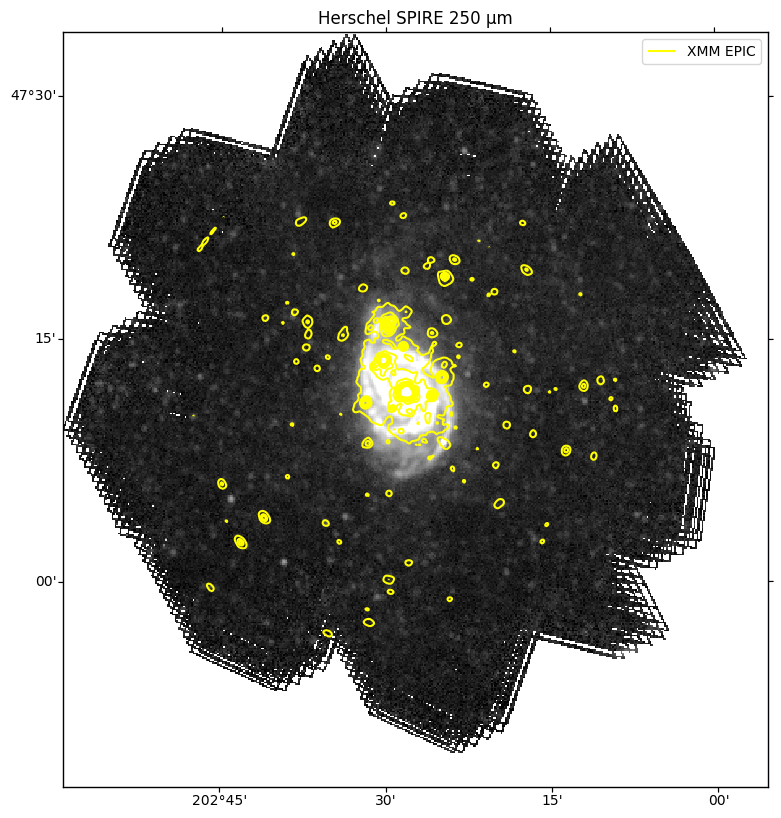

In [21]:
fig = plt.figure(figsize=(10,10),dpi=100)
pp = 98.0 # colour cut percentage
wcs_h = WCS(her_hdu['image'].header)
ax = fig.add_subplot(111,projection=wcs_h)
ax.set_title("Herschel SPIRE 250 µm")
norm_her = ImageNormalize(her_hdu['image'].data[~np.isnan(her_hdu['image'].data)],interval=PercentileInterval(pp), stretch=AsinhStretch())
ax.imshow(her_hdu['image'].data,cmap=plt.cm.gray,norm=norm_her,origin='lower',interpolation='nearest')
cs = ax.contour(xmm_sm5, transform=ax.get_transform(wcs), 
           levels=np.linspace(3,50,10),colors='yellow', label="XMM [0.2-7] keV")
plt.xlabel = 'RA'
plt.ylabel = 'Dec'
ax.legend([q for q in cs.collections],["XMM"])

In [18]:
cats = ESASky.query_region_catalogs(position='M51', radius='10 arcmin')
print (cats)

TableList with 9 tables:
	'0:HSC' with 8 column(s) and 10000 row(s) 
	'1:XMM-OM' with 12 column(s) and 2415 row(s) 
	'2:GAIA DR1' with 7 column(s) and 443 row(s) 
	'3:CHANDRA' with 13 column(s) and 38 row(s) 
	'4:HERSCHEL-SPSC-250' with 16 column(s) and 54 row(s) 
	'5:HERSCHEL-SPSC-500' with 16 column(s) and 6 row(s) 
	'6:XMM-EPIC' with 6 column(s) and 306 row(s) 
	'7:PLANCK-PCCS2-HFI' with 8 column(s) and 8 row(s) 
	'8:HERSCHEL-SPSC-350' with 16 column(s) and 24 row(s) 


In [19]:
catx= cats['PLANCK-PCCS2-HFI']
catx.info
# select only the 857 GHz sources
ix857 = np.where(catx['frequency'] == 857)[0]
src857 = catx[ix857]
src857

name,ra [1],dec [1],frequency [1],detflux [1],detflux_err [1],extended [1],highest_reliability_cat [1]
object,float64,float64,int32,float64,float64,int32,int32
PCCS2 857 G104.80+68.56,202.486587168,47.1817958665,857,46454.07,382.1489,1,99
PCCS2 857 G104.89+68.46,202.506142688,47.2927049669,857,8509.699,148.8071,1,99
PCCS2 857 G104.70+68.45,202.607032181,47.2694587382,857,2487.3816,144.50739,1,99
PCCS2 857 G104.65+68.65,202.507466191,47.0781546783,857,1935.9907,154.44075,1,99


Now let's combine everything into a final figure.

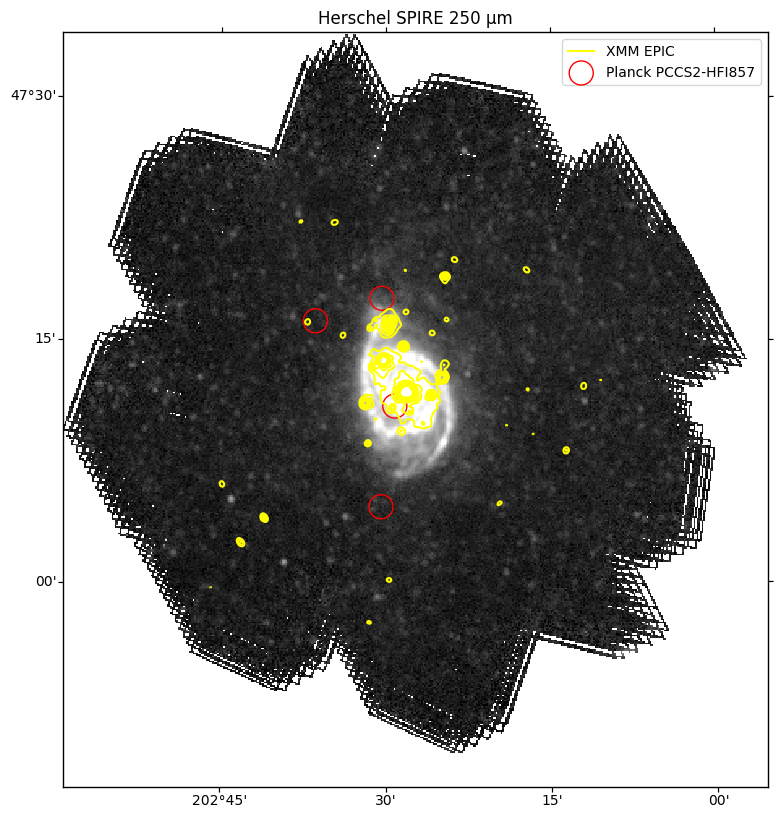

In [22]:
fig = plt.figure(figsize=(10,10),dpi=100)
pp = 95.0 # colour cut percentage
wcs_h = WCS(her_hdu['image'].header)
ax = fig.add_subplot(111,projection=wcs_h)
ax.set_title("Herschel SPIRE 250 µm")
ax.imshow(her_hdu['image'].data,cmap=plt.cm.gray,norm=norm_her,origin='lower',interpolation='nearest')
cs = ax.contour(xmm_sm5, transform=ax.get_transform(wcs), 
           levels=np.linspace(6,50,10),colors='yellow', label="XMM [0.2-7] keV")
p1 = ax.scatter(src857['ra'],src857['dec'],transform=ax.get_transform('world'), \
        s=300, edgecolor='red', facecolor='none', label='Planck PCCS2-HFI')
plt.xlabel = 'RA'
plt.ylabel = 'Dec'
ax.legend([[q for q in cs.collections][0],p1],["XMM EPIC","Planck PCCS2-HFI857"])


### Final notes

This simple example illustrated a simple usage of the esasky module wihtin astroquery and showed how to use ESA's archival data on XMM-EPIC, Herschel-SPIRE and Planck point source catalogue.

The final figure in the example shows some potential quality issues with the Planck PCCS2-HFI as the sources seem to be offset from the centre of M51 (NGC 5194) and its sattelite M51B (NGC 5195). 

There is a relatively good match between the SPIRE 250 µm map and the XMM-EPIC contours. 